In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio

Sklearn $\ge$ 0.19 is necessary for the efficient implementation of tsne.

In [2]:
import sklearn.manifold  
sklearn.__version__

'0.19.0'

### Pull the data from the internet and write it to a file
Don't bother running this if you've already downloaded the dataset. 

In [3]:
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

In [2]:
%%time
getData = True  # Change this to false the first time you run the notebook
if(getData): 
    results = requests.get('https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing')
#    model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#    model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

CPU times: user 313 ms, sys: 167 ms, total: 480 ms
Wall time: 5.07 s


### Read in from file and transform into a vector space

We add a filter to ensure that we only parse png files from our download zip.

In [9]:
#numericColumns = list(range(2,301))

In [3]:
#%time data = np.loadtxt('',skiprows=1,delimiter=" ",usecols=numericColumns)

In [4]:
#%time data = np.loadtxt('GoogleNews-vectors-negative300.txt',skiprows=1,delimiter=" ", )

In [57]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [56]:
%time data = pd.read_csv('GoogleNews-vectors-negative300.txt', nrows=100000, skiprows=1, header=None, sep=' ')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/jchealy/anaconda/envs/datascience/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-ac958a78e8e1>", line 1, in <module>
    get_ipython().magic("time data = pd.read_csv('GoogleNews-vectors-negative300.txt', nrows=100000, skiprows=1, header=None, sep=' ')")
  File "/Users/jchealy/anaconda/envs/datascience/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2158, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/Users/jchealy/anaconda/envs/datascience/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2079, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-59>", line 2, in time
  File "/Users/jchealy/anaconda/envs/datascience/lib/python3.5/site-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File 

FileNotFoundError: File b'GoogleNews-vectors-negative300.txt' does not exist

In [47]:
data.set_index(0, inplace=True)

In [48]:
data.head(3)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
</s>,0.001129,-0.000896,0.000319,0.001534,0.001106,-0.001404,-0.000031,-0.000420,-0.000576,0.001076,...,-0.001549,0.001373,-0.000061,-0.000824,0.001328,0.001160,0.000568,-0.001564,-0.000123,-0.000086
in,0.070312,0.086914,0.087891,0.062500,0.069336,-0.108887,-0.081543,-0.154297,0.020752,0.131836,...,-0.168945,-0.088867,-0.080566,0.064941,0.061279,-0.047363,-0.058838,-0.047607,0.014465,-0.062500
for,-0.011780,-0.047363,0.044678,0.063477,-0.018188,-0.063965,-0.001312,-0.072266,0.064453,0.086426,...,-0.022583,0.003723,-0.082520,0.081543,0.007935,0.000477,0.018433,0.071289,-0.034912,0.024170


Next we pull the object id's from the file names using pandas

### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

### Now let's use UMAP to embed these points into a two dimensional space.

In [49]:
fit = umap.UMAP(n_neighbors=15, random_state=42, metric='cosine')
%time u = fit.fit_transform(data)

CPU times: user 6min 29s, sys: 7.91 s, total: 6min 37s
Wall time: 6min 21s


In [63]:
embedding = pd.DataFrame({'word':data.index, 'x':u[:,0], 'y':u[:,1]})
embedding.to_csv("~/python/UMAP/umap_paper_notebooks/embedding_word_100_umap.csv")

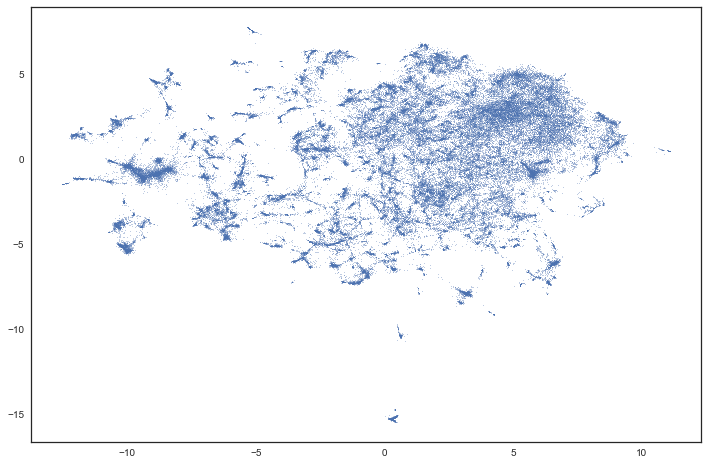

In [50]:
plt.scatter(u[:,0], u[:,1], s=0.1)

100,000 datapoints subsampled from our file results give a run time of (7min 4sec, 6 min 21sec) and results in lovely topological structure.


We see here that UMAP manages to preserve much of the loop structure that is inherent within the coil data set. The coil data set was constructed by taking 20 objects and photographing them at various rotations.  These rotations are being reveiled by the locality preserving property of UMAP.

TO DO: Look at the global structure in between the groups

### T-SNE

Perplexity 30 is finished in around 9 minutes

In [51]:
fit_tsne = sklearn.manifold.TSNE(perplexity=60)
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 3h 27min 23s, sys: 6min 9s, total: 3h 33min 32s
Wall time: 3h 30min 53s


In [69]:
embedding = pd.DataFrame({'word':data.index, 'x':u_tsne[:,0], 'y':u_tsne[:,1]})
embedding.to_csv("~/python/UMAP/umap_paper_notebooks/embedding_word_100_tsne.csv")

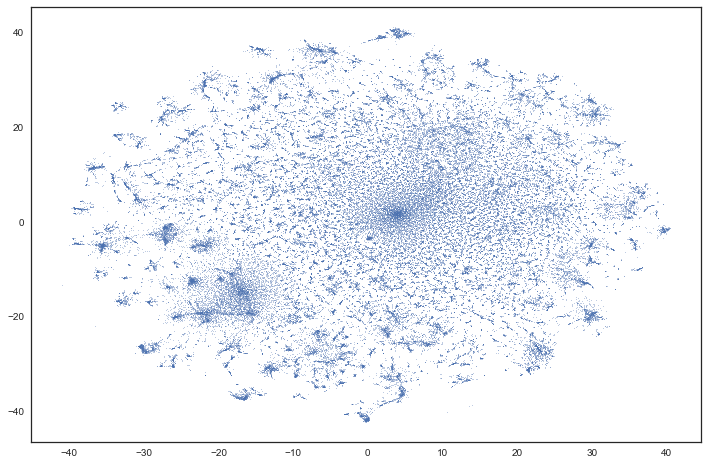

In [52]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], s=0.1)

t-SNE breaks more of the loops losing some of the loop structure inherent in COIL.  On the other hand it does a very good job of seperating the objects within COIL.

TO DO: Examine the global positioning of COIL objects.

## MDS

For old times sake we attempt to embed with multi-dimensional scaling.  Probably not worth running for the 100,000 use case.  Might try an overnight run though.

In [45]:
fit_mds = sklearn.manifold.MDS()
%time u_mds = fit_mds.fit_transform(data)

KeyboardInterrupt: 

In [ ]:
plt.scatter(u_mds[:,0], u_mds[:,1], s=10)

MDS and PCA (below) should do a better job preserving global structure at the expense of sacrificying local structure.  These can be seen in the loss of loop structure in our data and the dispersal of points across our space.

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 2.2 s, sys: 719 ms, total: 2.92 s
Wall time: 2.12 s


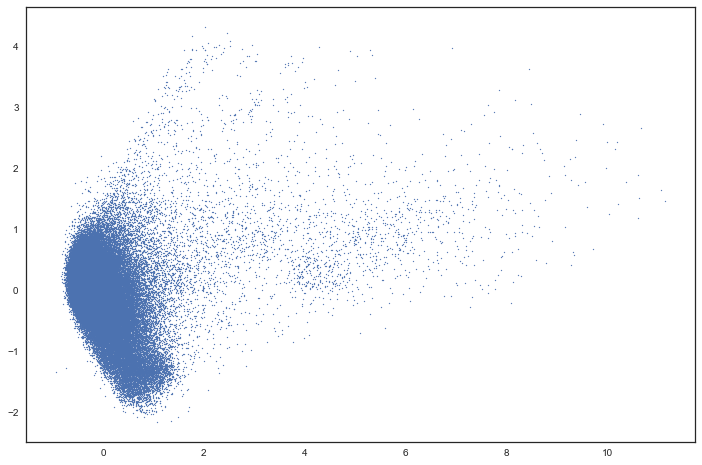

In [54]:
plt.scatter(u_pca[:,0], u_pca[:,1],  s=1)